In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from typing import NoReturn

### Метрики оценивания

In [2]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1           
                    
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

### Загрузка датасета

In [5]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=str), np.array(y, dtype=str)

In [6]:
X, y = read_dataset("spam")

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Naive Bayes

In [8]:
class NaiveBayes:
    def __init__(self, alpha: float):
        self.alpha = alpha
        self.classes = None
        self.n_classes = None
        self.log_theta = None        
        self.log_p_y = None
        
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        self.classes, counts = np.unique(y, return_counts=True)
        self.log_p_y = np.log(counts/np.sum(counts))
        
        self.n_classes = counts.shape[0]
        n_features = X.shape[1]
        
        theta = np.zeros((self.n_classes, n_features))
        
        for i, class_i in enumerate(self.classes):
            ind = np.where(y==class_i)          
            X_class_i = np.copy(X)[ind,:].squeeze()       
            div = np.sum(X_class_i)

            for j in range(n_features):
                theta[i, j] = (np.sum(X_class_i[:,j]) + self.alpha) / (div + self.alpha * n_features)
        
        self.log_theta = np.log(theta)
        
        
    def predict(self, X: np.ndarray) -> list:
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    
    def log_proba(self, X: np.ndarray) -> np.ndarray:
        matrix = np.zeros((X.shape[0], self.n_classes))
        
        for i, sentence in enumerate(X):
            for j, class_j in enumerate(self.classes):
                matrix[i, j] = np.sum(self.log_theta[j] * sentence)
                
        matrix += self.log_p_y        
        return matrix

### Bag of words

In [9]:
import string
def parse(X, is_sentence=False):
        if is_sentence:
            lst = X.split()
        else:
            lst = []
            for sentence in X:
                lst += sentence.split()

        for i, word in enumerate(lst):
            word = word.translate(str.maketrans('', '', string.punctuation))
            word = word.lower()
            lst[i] = word
        
        lst = [word for word in lst if word != '']
        return lst

In [10]:
class BoW:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):    
        lst = parse(X)
        unique, counts = np.unique(lst, return_counts=True)        
        self.dict = unique[np.argsort(counts)][::-1][:voc_limit]
        self.vocab_size = self.dict.shape[0]

        
    def transform(self, X: np.ndarray) -> np.ndarray:
        lst = [parse(X[i], is_sentence=True) for i in range(X.shape[0])]
        embeddings = np.zeros((X.shape[0], self.vocab_size))            
        
        for i, sentence in enumerate(lst):
            unique, counts = np.unique(sentence, return_counts=True)
            for word, freq in zip(unique, counts):  
                indx = np.where(self.dict==word)[0]
                embeddings[i, indx] = freq
                
        return embeddings

### Проверка

In [11]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [12]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9736842105263158, 'spam': 0.90625},
 {'ham': 0.9876796714579056, 'spam': 0.8169014084507042},
 0.9659498207885304)

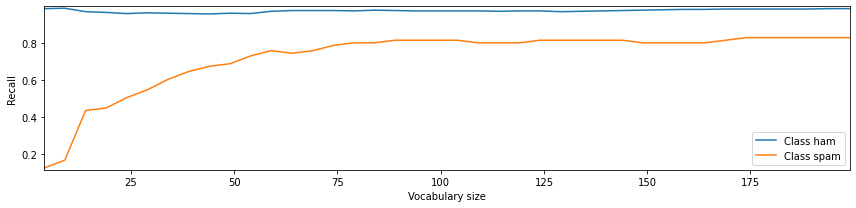

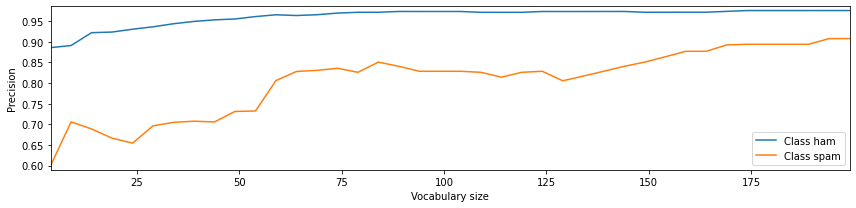

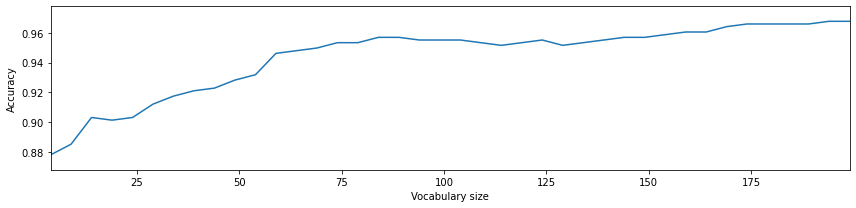

In [13]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Stemming

In [14]:
stemmer = SnowballStemmer("english")

In [15]:
class BowStem:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        lst_ = parse(X)
        lst = ['nothing' for i in range(len(lst_))]
        for i, word in enumerate(lst_):
            lst[i] = stemmer.stem(word)    

        unique, counts = np.unique(lst, return_counts=True)        
        self.dict = unique[np.argsort(counts)][::-1][:voc_limit]
        self.vocab_size = self.dict.shape[0]
        
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        lst = [parse(X[i], is_sentence=True) for i in range(X.shape[0])]

        for i, sentence in enumerate(lst):
            for j, word in enumerate(sentence):
                sentence[j] = stemmer.stem(word)
            lst[i] = sentence
     
        embeddings = np.zeros((X.shape[0], self.vocab_size))            
        
        for i, sentence in enumerate(lst):    
            unique, counts = np.unique(sentence, return_counts=True)
            for word, freq in zip(unique, counts):  
                indx = np.where(self.dict==word)[0]
                embeddings[i, indx] = freq
                
        return embeddings

### Проверка

In [16]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [17]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9795918367346939, 'spam': 0.8970588235294118},
 {'ham': 0.9856262833675564, 'spam': 0.8591549295774648},
 0.9695340501792115)

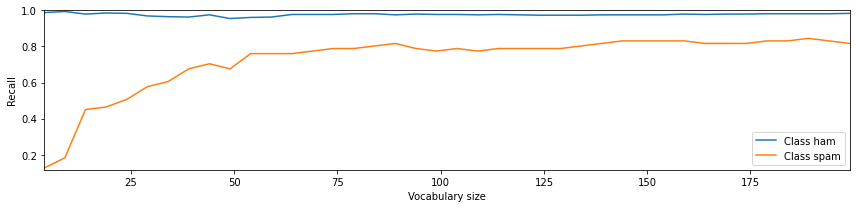

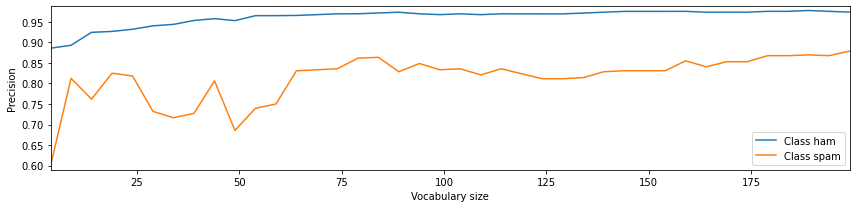

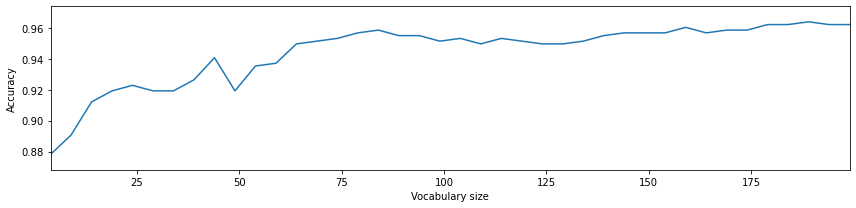

In [18]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)